In [1]:
from pathlib import Path

fig_path = Path('figures')

In [2]:
import numpy as np
from tqdm import tqdm

In [3]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.patches import Polygon
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [4]:
num_rows = 3
num_cols = 4
num_action = 4

encode = lambda i, j: i * num_cols + j
decode = lambda s: (s // num_cols, s % num_cols)


In [5]:
def plot(q, terminals=None, plot_colorbar=False, plot_arrows=True):
    terminals = [] if terminals is None else terminals

    fig, ax = plt.subplots(figsize=(1.5 * num_cols, 1.5 * num_rows))
    ax.set_aspect('equal')
    ax.set_xlim(-.5, num_cols - .5)
    ax.set_ylim(-.5, num_rows - .5)
    ax.invert_yaxis()
    ax.set_axis_off()

    norm = mpl.colors.Normalize(vmin=q.min(), vmax=q.max())
    cmap = mpl.colormaps['RdYlGn']

    d1 = np.array([[-1, -1], [1, -1], [1, 1], [-1, 1], [-1, -1]])
    d2 = np.array([[0, -1], [1, 0], [0, 1], [-1, 0]])

    for i in range(num_rows):
        for j in range(num_cols):
            if (i, j) in terminals:
                continue
            s = encode(i, j)
            m = q[s].max()
            center = np.array([j, i])
            # ax.text(*center, str(s), color='w', ha='center', va='center')
            for a in range(num_action):
                ax.add_patch(Polygon([center, center + .49 * d1[a], center + .49 * d1[a + 1]], fc=cmap(norm(q[s, a]))))
                ax.text(*(center + .33 * d2[a]), s=f'{q[s, a]:.1f}', ha='center', va='center')
                if plot_arrows and q[s, a] == m:
                    ax.arrow(*center, *(.1 * d2[a]), color='k', lw=2, head_width=.1, head_length=.05, zorder=10)

    for i, j in terminals:
        center = np.array([j, i])
        ax.add_patch(Polygon(center + .49 * d1, fc=cmap(1.)))

    if plot_colorbar:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size='2%', pad=0.05)
        fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)

    fig.tight_layout()
    return fig, ax


In [6]:
def get_transition_rewards(state_rewards, obstacles):
    transition = [[0 for a in range(num_action)] for s in range(num_cols * num_rows)]
    rewards = np.zeros([num_cols * num_rows, num_action])
    for i in range(num_rows):
        for j in range(num_cols):
            s = encode(i, j)
            for a in range(num_action):
                di, dj = [(-1, 0), (0, 1), (1, 0), (0, -1)][a]
                i_, j_ = i + di, j + dj
                transition[s][a] = s if (i_, j_) in obstacles else encode(i_, j_)
                rewards[s][a] = state_rewards[(i_, j_)]
    return transition, rewards


def get_step(terminals, transition, rewards):
    def step(s, a):
        if decode(s) in terminals:
            return None, None, True
        else:
            return transition[s][a], rewards[s][a], False

    return step


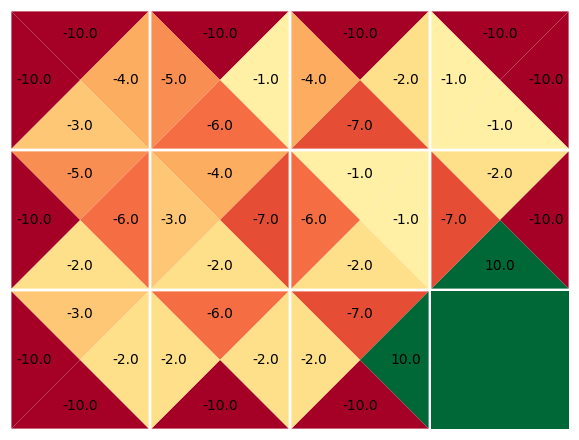

In [7]:
initial_observation = encode(2, 0)
state_rewards = {
    (0, 0): -5, (0, 1): -4, (0, 2): -1, (0, 3): -2,
    (1, 0): -3, (1, 1): -6, (1, 2): -7, (1, 3): -1,
    (2, 0): -2, (2, 1): -2, (2, 2): -2, (2, 3): 0,
}
boundary = ([(-1, j) for j in range(num_cols)] + [(num_rows, j) for j in range(num_cols)] +
            [(i, -1) for i in range(num_rows)] + [(i, num_cols) for i in range(num_rows)])
obstacles = {b: -10 for b in boundary}
terminals = {(num_rows - 1, num_cols - 1): 10}

state_rewards = state_rewards | obstacles | terminals

transition, rewards = get_transition_rewards(state_rewards, obstacles)
step = get_step(terminals, transition, rewards)

fig, ax = plot(rewards, terminals, plot_arrows=False)
fig.savefig(fig_path / 'grid_env.pdf')

In [8]:
def epsilon_greedy(qs, epsilon=0.3):
    if np.random.uniform(0, 1) < epsilon:
        action = np.random.randint(len(qs))
    else:
        action = int(np.argmax(qs))
    return action


def update_statistic(tau, observation, action, reward, next_observation, update, post, lr=1):
    next_action = post(update(reward, tau[next_observation])).argmax()
    estimation = update(reward, tau[next_observation, next_action])
    tau[observation, action] += lr * (estimation - tau[observation, action])


In [9]:
# aggregation_name = 'sum'
# init = np.array([0.])
# update = lambda r, s: r + s
# post = np.squeeze

aggregation_name = 'dsum'
init = np.array([0.])
update = lambda r, s: r + .9 * s
post = np.squeeze

# aggregation_name = 'max'
# init = np.array([rewards.min()])
# update = lambda r, s: np.maximum(r, s)
# post = np.squeeze

# aggregation_name = 'dmax'
# init = np.array([rewards.min()])
# update = lambda r, s: np.maximum(r, .9 * s)
# post = np.squeeze

# aggregation_name = 'log-sum-exp'
# init = np.array([rewards.min()])
# update = lambda r, s: np.log(np.exp(r) + np.exp(s))
# post = np.squeeze

# aggregation_name = 'min'
# init = np.array([rewards.max()])
# update = lambda r, s: np.minimum(r, s)
# post = np.squeeze

# aggregation_name = 'dmin'
# init = np.array([rewards.max()])
# update = lambda r, s: np.minimum(r, .9 * s)
# post = np.squeeze

# aggregation_name = 'range'
# init = np.array([rewards.min(), rewards.max()]) # [max, min]
# update = lambda r, tau: np.stack([np.maximum(r, tau[..., 0]), np.minimum(r, tau[..., 1])], axis=-1)
# post = lambda tau: tau[..., 0] - tau[..., 1]

# aggregation_name = 'mean'
# init = np.array([1e-12, 0.]) # [count, sum]
# update = lambda r, tau: tau + np.array([1, r])
# post = lambda tau: tau[..., 1] / tau[..., 0]

# aggregation_name = 'variance'
# init = np.array([1e-3, 0., 0.]) # [count, sum, square sum]
# update = lambda r, tau: tau + np.array([1, r, r ** 2])
# post = lambda tau: tau[..., 2] / tau[..., 0] - (tau[..., 1] / tau[..., 0]) ** 2

# aggregation_name = 'sharpe'
# init = np.array([1e-3, 0., 0.]) # [count, sum, square sum]
# update = lambda r, tau: tau + np.array([1, r, r ** 2])
# post = lambda tau: (tau[..., 1] / tau[..., 0]) / np.sqrt(tau[..., 2] / tau[..., 0] - (tau[..., 1] / tau[..., 0]) ** 2 + 1e-12)

# k = 1.5

# # max - k * range = (1 - k) * max + k * min
# aggregation_name = f'{k:.1f}min{1 - k:+.1f}max'
# init = np.array([rewards.min(), rewards.max()]) # [max, min]
# update = lambda r, tau: np.stack([np.maximum(r, tau[..., 0]), np.minimum(r, tau[..., 1])], axis=-1)
# post = lambda tau: (1 - k) * tau[..., 0] + k * tau[..., 1]

# # mean - k * std
# aggregation_name = f"mean-{k:.1f}std"
# init = np.array([1e-3, 0.0, 0.0])  # [count, sum, square sum]
# update = lambda r, tau: tau + np.array([1, r, r**2])
# post = lambda tau: tau[..., 1] / tau[..., 0] - k * np.sqrt(tau[..., 2] / tau[..., 0] - (tau[..., 1] / tau[..., 0]) ** 2)


100%|██████████| 10001/10001 [00:00<00:00, 27121.03it/s]


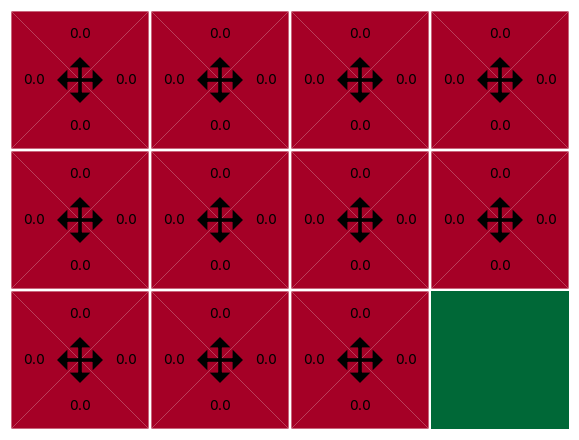

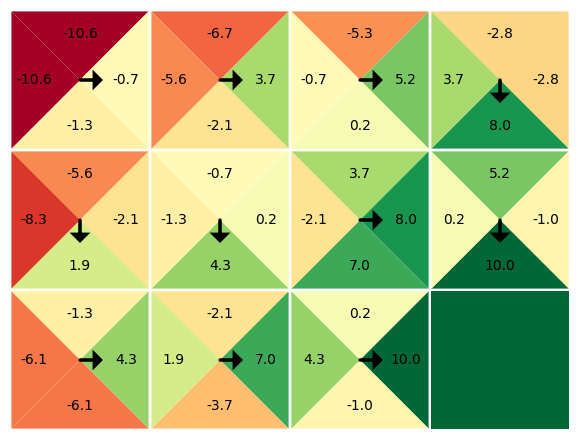

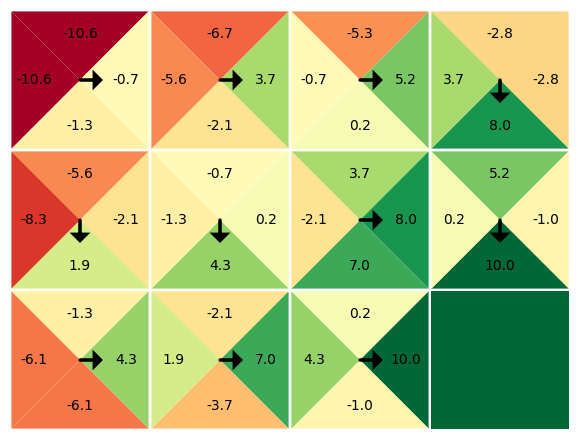

In [10]:
tau = np.repeat(np.repeat(init[None, None,], num_action, axis=1), num_rows * num_cols, axis=0)

for episode in tqdm(range(10001)):
    if episode % 5000 == 0:
        fig, ax = plot(post(tau), terminals, plot_arrows=True)

    observation = initial_observation
    terminated = False
    while not terminated:
        action = epsilon_greedy(post(tau[observation]))
        next_observation, reward, terminated = step(observation, action)
        if not terminated:
            update_statistic(tau, observation, action, reward, next_observation, update, post)
            observation = next_observation

fig.savefig(fig_path / f'grid_{aggregation_name}.pdf')